In [1]:
!pip install DeepXDE

  Using cached DeepXDE-1.10.1-py3-none-any.whl (172 kB)
  Using cached scikit_optimize-0.10.2-py2.py3-none-any.whl (107 kB)
  Using cached numpy-1.24.4-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
  Using cached packaging-24.1-py3-none-any.whl (53 kB)
  Using cached pyaml-24.9.0-py3-none-any.whl (24 kB)
  Using cached scikit_learn-1.3.2-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.1 MB)
  Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: joblib
    Found existing installation: joblib 1.0.1
    Uninstalling joblib-1.0.1:
      Successfully uninstalled joblib-1.0.1
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1
  Attempting uninstall: packaging
  

In [2]:
!pip install pyarrow

  Using cached pyarrow-17.0.0-cp38-cp38-manylinux_2_28_x86_64.whl (40.0 MB)


In [3]:
pip install --upgrade torch

  Using cached torch-2.4.1-cp38-cp38-manylinux1_x86_64.whl (797.1 MB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached typing_extensions-4.12.2-py3-none-any.whl (37 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached triton-3.0.0-1-cp38-cp38-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (209.4 MB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl (664.8 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached filelock-3.16.1-py3-none-any.whl (16 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached

In [4]:
import torch
print(torch.__version__)

2.4.1+cu121


In [5]:
import os
os.environ["DDE_BACKEND"] = "pytorch"

In [6]:
import numpy as np
import deepxde as dde
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
import pandas as pd
import pyarrow as pa
import pyarrow.orc as orc
from IPython.display import display

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [7]:
x_l = -20
x_r = 20
t_lower = 0
t_upper = 0.1

x = np.linspace(x_l, x_r, 200)
t = np.linspace(t_lower, t_upper, 50)
X, T = np.meshgrid(x, t)

X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))

space_domain = dde.geometry.Interval(x_l, x_r)
time_domain = dde.geometry.TimeDomain(t_lower, t_upper)
geomtime = dde.geometry.GeometryXTime(space_domain, time_domain)


k = 1
χ = 1
a = 0.5
x_0 = 15
θ_0 = np.pi / 3

a1 = 1
a2 = 1
a4 = 0.2
a6 = 0.1

b1 = 1

A1 = np.sqrt((2 * χ / b1) * (a2 - 6 * a4 * k ** 2 + 12 * a4 * k + 10 * a4 + 75 * a6 * k ** 4 + 150 * a6 * k ** 2 + 91 * a6))
C0 = a1 + 2 * a2 * k + 8 * a4 * k ** 3 + 96 * a6 * k ** 5
ω = a1 * k + a2 * k ** 2 - a2 + 3 * a4 * k ** 4 - 6 * a4 * k ** 2 - a4 + 35 * a6 * k ** 6 - 75 * a6 * k ** 4 - 15 * a6 * k ** 2 - a6

a3 = -4 * a4 * k - 40 * a6 * k ** 3
a5 = -6 * a6 * k

b2 = - (24 * a4 * χ ** 2 + 360 * a6 * χ ** 2 * k ** 2 + 840 * a6 * χ ** 2) / A1 ** 4
b3 = 720 * a6 * χ ** 3 / A1 ** 6


def pde(x, y):
    u = y[:, 0:1]
    v = y[:, 1:2]

    u_t = dde.grad.jacobian(y, x, i=0, j=1)
    v_t = dde.grad.jacobian(y, x, i=1, j=1)

    u_x = dde.grad.jacobian(y, x, i=0, j=0)
    v_x = dde.grad.jacobian(y, x, i=1, j=0)

    u_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    v_xx = dde.grad.hessian(y, x, component=1, i=0, j=0)

    u_xxx = dde.grad.jacobian(u_xx, x, j=0)
    v_xxx = dde.grad.jacobian(v_xx, x, j=0)

    u_xxxx = dde.grad.jacobian(u_xxx, x, j=0)
    v_xxxx = dde.grad.jacobian(v_xxx, x, j=0)

    u_xxxxx = dde.grad.jacobian(u_xxxx, x, j=0)
    v_xxxxx = dde.grad.jacobian(v_xxxx, x, j=0)

    u_xxxxxx = dde.grad.jacobian(u_xxxxx, x, j=0)
    v_xxxxxx = dde.grad.jacobian(v_xxxxx, x, j=0)

    f_u = -v_t - a1 * v_x + a2 * u_xx - a3 * v_xxx + a4 * u_xxxx - a5 * v_xxxxx + a6 * u_xxxxxx + u * (b1 * (u ** 2 + v ** 2) + b2 * (u ** 2 + v ** 2) ** 2 + b3 * (u ** 2 + v ** 2) ** 3)
    f_v = u_t + a1 * u_x + a2 * v_xx + a3 * u_xxx + a4 * v_xxxx + a5 * u_xxxxx + a6 * v_xxxxxx + v * (b1 * (u ** 2 + v ** 2) + b2 * (u ** 2 + v ** 2) ** 2 + b3 * (u ** 2 + v ** 2) ** 3)

    return [f_u, f_v]


bc_u_0 = dde.icbc.DirichletBC(
    geomtime, lambda _: 0, lambda _, on_boundary: on_boundary, component=0
)
bc_v_0 = dde.icbc.DirichletBC(
    geomtime, lambda _: 0, lambda _, on_boundary: on_boundary, component=1
)


bc_u_1 = dde.icbc.NeumannBC(
    geomtime, lambda _: 0, lambda _, on_boundary: on_boundary, component=0
)
bc_v_1 = dde.icbc.NeumannBC(
    geomtime, lambda _: 0, lambda _, on_boundary: on_boundary, component=1
)


bc_u_2 = dde.icbc.OperatorBC(
    geomtime, lambda x, u, _: dde.grad.hessian(u, x, i=0, j=0),
    lambda _, on_boundary: on_boundary
)
bc_v_2 = dde.icbc.OperatorBC(
    geomtime, lambda x, v, _: dde.grad.hessian(v, x, i=0, j=0),
    lambda _, on_boundary: on_boundary
)


def init_cond_u(x):
    exp = np.exp(np.float32(x[:, 0:1] + x_0))

    return np.cos(k * x[:, 0:1] + θ_0) * (A1 / (a * exp + χ / (4 * a * exp)))


def init_cond_v(x):
    exp = np.exp(np.float32(x[:, 0:1] + x_0))

    return np.sin(k * x[:, 0:1] + θ_0) * (A1 / (a * exp + χ / (4 * a * exp)))


ic_u = dde.icbc.IC(geomtime, init_cond_u, lambda _, on_initial: on_initial, component=0)
ic_v = dde.icbc.IC(geomtime, init_cond_v, lambda _, on_initial: on_initial, component=1)


data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_u_0, bc_u_1, bc_u_2, bc_v_0, bc_v_1, bc_v_2, ic_u, ic_v],
    num_domain=10000,
    num_boundary=200,
    num_initial=3000,
    train_distribution="pseudo",
)

net = dde.nn.FNN([2] + [30] * 3 + [2], "sin", "Glorot normal")

model = dde.Model(data, net)

opt = torch.optim.Adam(model.net.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

model.compile(optimizer=opt, lr=0.01, loss="MSE",
              loss_weights=(1., 1., 1., 1., 1., 1., 1., 1., 5., 5.),
              decay=("inverse time", 100, 0.01143))
model.train(iterations=30000, display_every=1000, callbacks=[dde.callbacks.PDEPointResampler(period=10)])

Compiling model...
'compile' took 0.000185 s

Training model...

Step      Train loss                                                                                              Test loss                                                                                               Test metric
0         [2.27e-01, 2.37e-01, 8.38e-02, 7.41e-04, 4.35e-04, 1.01e-01, 3.25e-02, 4.35e-04, 8.08e+00, 1.59e+01]    [2.27e-01, 2.37e-01, 8.38e-02, 7.41e-04, 4.35e-04, 1.01e-01, 3.25e-02, 4.35e-04, 8.08e+00, 1.59e+01]    []  
1000      [1.46e-01, 1.70e-01, 7.70e-04, 2.21e-03, 9.29e-04, 2.42e-04, 9.84e-04, 9.29e-04, 7.06e-02, 9.93e-02]    [1.48e-01, 1.59e-01, 7.70e-04, 2.21e-03, 9.29e-04, 2.42e-04, 9.84e-04, 9.29e-04, 7.06e-02, 9.93e-02]    []  
2000      [1.16e-01, 1.25e-01, 3.94e-04, 1.36e-03, 1.57e-03, 2.64e-04, 8.04e-04, 1.57e-03, 3.95e-02, 6.67e-02]    [1.14e-01, 1.32e-01, 3.94e-04, 1.36e-03, 1.57e-03, 2.64e-04, 8.04e-04, 1.57e-03, 3.95e-02, 6.67e-02]    []  
3000      [6.49e-02, 6.11e-02, 3.11e

(<deepxde.model.LossHistory at 0x7f690a87c3a0>,
 <deepxde.model.TrainState at 0x7f690a9a6b80>)

In [8]:
model.compile("L-BFGS", lr=dde.optimizers.set_LBFGS_options(maxcor=50, ftol=1.0 * np.finfo(float).eps, gtol=1e-5, maxiter=15000, maxfun=50000, maxls=25), loss="MSE")
model.train(iterations=10000, display_every=1000)

Compiling model...
'compile' took 0.000445 s

Training model...

Step      Train loss                                                                                              Test loss                                                                                               Test metric
30000     [2.77e-03, 2.75e-03, 4.82e-04, 4.60e-04, 8.44e-05, 3.28e-05, 4.65e-05, 8.44e-05, 5.08e-04, 7.73e-04]    [2.80e-03, 2.72e-03, 4.82e-04, 4.60e-04, 8.44e-05, 3.28e-05, 4.65e-05, 8.44e-05, 5.08e-04, 7.73e-04]    []  
31000     [1.12e-03, 9.71e-04, 3.07e-04, 2.63e-04, 9.07e-05, 3.11e-05, 1.46e-05, 9.07e-05, 5.59e-04, 6.04e-04]    [1.28e-03, 1.09e-03, 3.07e-04, 2.63e-04, 9.07e-05, 3.11e-05, 1.46e-05, 9.07e-05, 5.59e-04, 6.04e-04]    []  
32000     [6.18e-04, 6.30e-04, 3.78e-04, 2.13e-04, 5.83e-05, 1.75e-05, 1.53e-05, 5.83e-05, 4.05e-04, 3.71e-04]    [7.15e-04, 6.75e-04, 3.78e-04, 2.13e-04, 5.83e-05, 1.75e-05, 1.53e-05, 5.83e-05, 4.05e-04, 3.71e-04]    []  
33000     [3.98e-04, 4.31e-04, 3.90e

(<deepxde.model.LossHistory at 0x7f690a87c3a0>,
 <deepxde.model.TrainState at 0x7f690a9a6b80>)

In [9]:
prediction = model.predict(X_star)

u = griddata(X_star, prediction[:, 0], (X, T), method="cubic")
v = griddata(X_star, prediction[:, 1], (X, T), method="cubic")

q = np.sqrt(u ** 2 + v ** 2)

def u_exact(x, t):
    return np.cos(k * x - ω * t + θ_0) * (A1 / (a * np.exp(x - C0 * t + x_0) + χ * np.exp(-(x - C0 * t + x_0)) / (4 * a)))


def v_exact(x, t):
    return np.sin(k * x - ω * t + θ_0) * (A1 / (a * np.exp(x - C0 * t + x_0) + χ * np.exp(-(x - C0 * t + x_0)) / (4 * a)))


def q_exact(x, t):
    return A1 / (a * np.exp(x - C0 * t + x_0) + χ * np.exp(-(x - C0 * t + x_0)) / (4 * a))


data_ = {'x': X.flatten(), 't': T.flatten(), 'pred_u': u.flatten(), 'pred_v': v.flatten(), 'pred_h': q.flatten(),
        'true_u': u_exact(X, T).flatten(), 'true_v': v_exact(X, T).flatten(), 'true_h': q_exact(X, T).flatten()
         }

df = pd.DataFrame(data_)
table = pa.Table.from_pandas(df)
orc.write_table(table, 'my_data_2_1.orc')
display(df)

,x,t,pred_u,pred_v,pred_h,true_u,true_v,true_h
0,-20.000000,0.0,0.061930,-0.001185,0.061942,1.134163e-01,-1.175163e-02,1.140235e-01
1,-19.798995,0.0,0.072875,0.009566,0.073500,1.387399e-01,1.360638e-02,1.394055e-01
2,-19.597990,0.0,0.085174,0.037672,0.093133,1.628857e-01,5.016585e-02,1.704358e-01
3,-19.396985,0.0,0.098107,0.083348,0.128732,1.828846e-01,9.985538e-02,2.083696e-01
4,-19.195980,0.0,0.109237,0.146741,0.182936,1.947089e-01,1.642587e-01,2.547400e-01
...,...,...,...,...,...,...,...,...
9995,19.195980,0.1,0.000130,0.003545,0.003547,-3.500951e-14,9.221965e-14,9.864142e-14
9996,19.396985,0.1,0.000531,0.002695,0.002747,-4.311741e-14,6.819158e-14,8.067963e-14
9997,19.597990,0.1,0.000519,0.001697,0.001774,-4.569167e-14,4.761050e-14,6.598854e-14
9998,19.798995,0.1,0.000122,0.000840,0.000849,-4.439391e-14,3.069561e-14,5.397258e-14


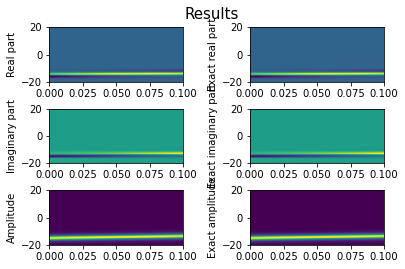

In [10]:
fig, ax = plt.subplots(3, 2)

plt.suptitle("Results", fontsize=15, x=0.5, y=0.95)

ax[0, 0].set_ylabel("Real part")
ax[0, 0].imshow(
    u.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_l, x_r],
    origin="lower",
    aspect="auto",
)
ax[1, 0].set_ylabel("Imaginary part")
ax[1, 0].imshow(
    v.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_l, x_r],
    origin="lower",
    aspect="auto",
)
ax[2, 0].set_ylabel("Amplitude")
ax[2, 0].imshow(
    q.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_l, x_r],
    origin="lower",
    aspect="auto",
)

ax[0, 1].set_ylabel("Exact real part")
ax[0, 1].imshow(
    u_exact(X, T).T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_l, x_r],
    origin="lower",
    aspect="auto",
)
ax[1, 1].set_ylabel("Exact imaginary part")
ax[1, 1].imshow(
    v_exact(X, T).T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_l, x_r],
    origin="lower",
    aspect="auto",
)
ax[2, 1].set_ylabel("Exact amplitude")
ax[2, 1].imshow(
    q_exact(X, T).T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_l, x_r],
    origin="lower",
    aspect="auto",
)

plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.show()

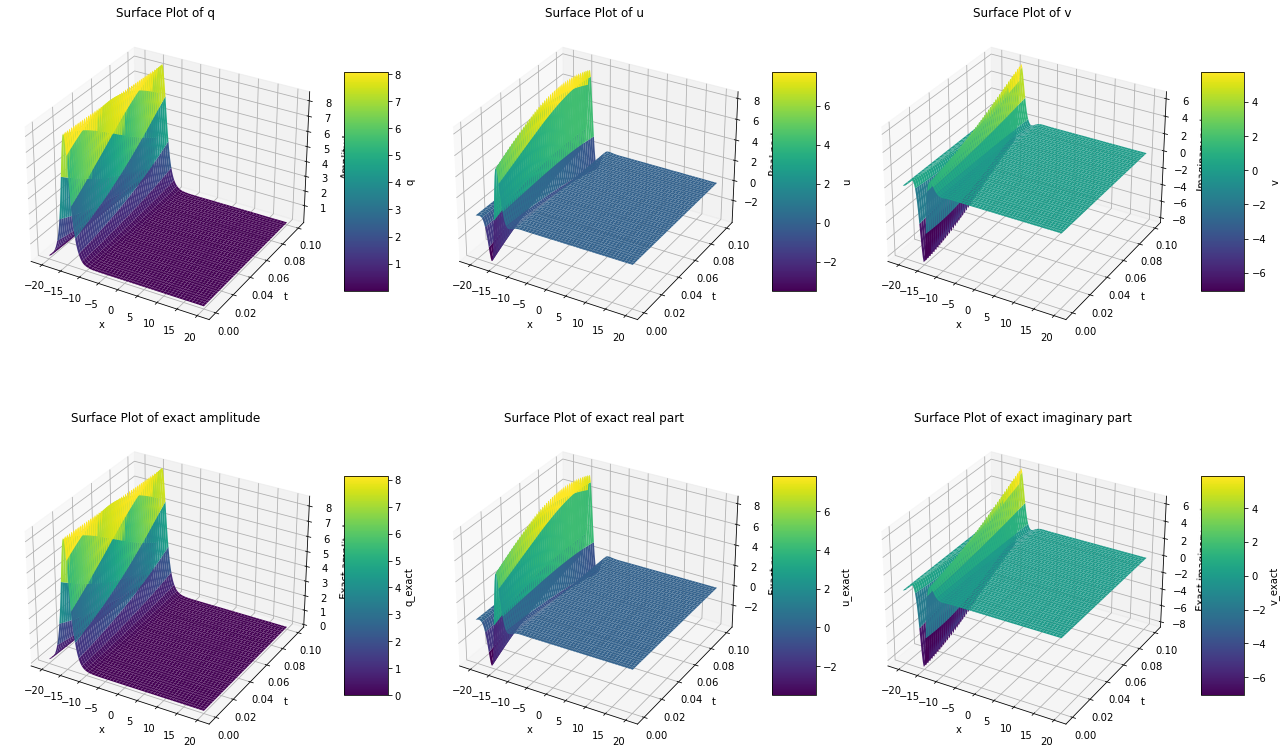

In [11]:
fig = plt.figure(figsize=(18, 12))

ax1 = fig.add_subplot(231, projection='3d')
surf1 = ax1.plot_surface(X, T, q, cmap='viridis', edgecolor='none')
cbar1 = fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=5)
cbar1.set_label('q')
ax1.set_xlabel('x')
ax1.set_ylabel('t')
ax1.set_zlabel('Amplitude')
ax1.set_title('Surface Plot of q')

ax2 = fig.add_subplot(232, projection='3d')
surf2 = ax2.plot_surface(X, T, u, cmap='viridis', edgecolor='none')
cbar2 = fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=5)
cbar2.set_label('u')
ax2.set_xlabel('x')
ax2.set_ylabel('t')
ax2.set_zlabel('Real part')
ax2.set_title('Surface Plot of u')

ax3 = fig.add_subplot(233, projection='3d')
surf3 = ax3.plot_surface(X, T, v, cmap='viridis', edgecolor='none')
cbar3 = fig.colorbar(surf3, ax=ax3, shrink=0.5, aspect=5)
cbar3.set_label('v')
ax3.set_xlabel('x')
ax3.set_ylabel('t')
ax3.set_zlabel('Imaginary part')
ax3.set_title('Surface Plot of v')

ax4 = fig.add_subplot(234, projection='3d')
surf4 = ax4.plot_surface(X, T, q_exact(X, T), cmap='viridis', edgecolor='none')
cbar4 = fig.colorbar(surf4, ax=ax4, shrink=0.5, aspect=5)
cbar4.set_label('q_exact')
ax4.set_xlabel('x')
ax4.set_ylabel('t')
ax4.set_zlabel('Exact amplitude')
ax4.set_title('Surface Plot of exact amplitude')

ax5 = fig.add_subplot(235, projection='3d')
surf5 = ax5.plot_surface(X, T, u_exact(X, T), cmap='viridis', edgecolor='none')
cbar5 = fig.colorbar(surf5, ax=ax5, shrink=0.5, aspect=5)
cbar5.set_label('u_exact')
ax5.set_xlabel('x')
ax5.set_ylabel('t')
ax5.set_zlabel('Exact real part')
ax5.set_title('Surface Plot of exact real part')

ax6 = fig.add_subplot(236, projection='3d')
surf6 = ax6.plot_surface(X, T, v_exact(X, T), cmap='viridis', edgecolor='none')
cbar6 = fig.colorbar(surf6, ax=ax6, shrink=0.5, aspect=5)
cbar6.set_label('v_exact')
ax6.set_xlabel('x')
ax6.set_ylabel('t')
ax6.set_zlabel('Exact imaginary part')
ax6.set_title('Surface Plot of exact imaginary part')

plt.tight_layout()
plt.show()

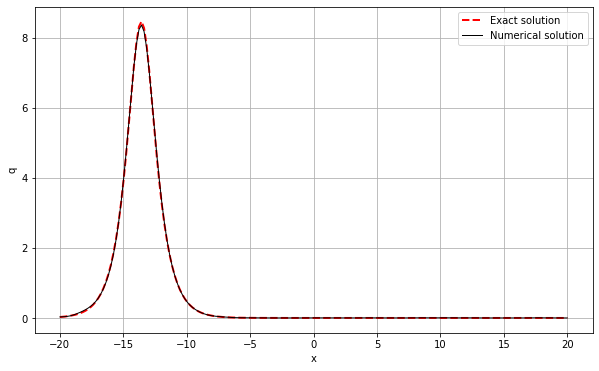

In [12]:
q_exact_values = q_exact(x, t_upper)

plt.figure(figsize=(10, 6))
plt.plot(x, q_exact_values, 'r--', label='Exact solution', linewidth=2)
plt.plot(x, q[-1, :], 'k-', label='Numerical solution', linewidth=1)
plt.xlabel('x')
plt.ylabel('q')
plt.legend()
plt.grid()
plt.show()